In [1]:
import os
import sys
import json
import argparse
from time import time
from functools import partial

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import normalize
from graspologic.cluster import GaussianCluster as GMM

from sklearn.model_selection import StratifiedKFold as KFold
from rsq.samplers import *
from rsq.samplers import _Sampler
from rsq.helpers import set_seeds
from rsq import SVCEnsemble

from pulearn import BaggingPuClassifier
from pulearn import ElkanotoPuClassifier

from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import ClassifierMixin

import pickle

from joblib import Parallel, delayed

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

In [2]:
data = pickle.load(open('../../../data/train_frontal_Bit_m-r101x1_with_labels.p', 'rb'))

In [3]:
X_all = np.array([vec for vec in data['vector']])

# category_indices = np.array([6,8,10,11,12,13,14,15,16,17,18])
category_indices = np.array([6,8,10,11,12,13,14,15,16,18])

conditions = np.array(list(data.iloc[0, category_indices].keys()))

competition_conditions = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
competition_conditions_indices = [np.where(conditions == c)[0][0] for c in conditions]


labels = np.arange(len(category_indices))

n, d = X_all.shape
y_all = np.zeros(n)

fly_list = []
for i in range(n):
    temp_conditions = data.iloc[i, category_indices]
    positive_conditions = np.where(temp_conditions.values.astype(int) > 0)[0]
    
    if len(positive_conditions) > 1:
        temp_competition_condition_indices = []
        for pc in positive_conditions:
            if pc in competition_conditions_indices:
                temp_competition_condition_indices.append(pc)
        if len(temp_competition_condition_indices) == 1:
            y_all[i] = temp_competition_condition_indices[0]
            fly_list.append(i)
    elif len(positive_conditions) == 1:
        y_all[i] = positive_conditions[0]
        fly_list.append(i)
        
fly_list = np.array(fly_list)
X = X_all[fly_list]
y = y_all[fly_list]

In [4]:
idx_by_label = [np.where(y == c)[0] for c in np.unique(y)]

[print(len(ibl), conditions[i]) for i, ibl in enumerate(idx_by_label)]

16974 No Finding
5591 Cardiomegaly
2535 Lung Lesion
13836 Edema
3378 Consolidation
1622 Pneumonia
7590 Atelectasis
7708 Pneumothorax
27420 Pleural Effusion
3079 Fracture


[None, None, None, None, None, None, None, None, None, None]

In [7]:
def svc_exp(X, y, p=0.1, acorn=None):
    X = X.copy() / np.sqrt((X.copy() ** 2).sum(axis=-1, keepdims=True))
    
    inds_sup = stratified_sample(y, p, replace=False)
    inds_unsup = np.array([i for i in range(len(y)) if i not in inds_sup])

    y_ = -1 * np.ones(n)
    y_[inds_sup] = y[inds_sup]
    
    #- 2 = Supervised, Semisupervised
    accs = np.zeros(2)
    
        
    #- Supervised
    svc_sup = SVC()
    svc_sup.fit(X[inds_sup], y[inds_sup])
    accs[0] = (svc_sup.predict(X[inds_unsup]) == y[inds_unsup]).mean()
    
    #- Semi-Supervised
    svc_semisup = SVCEnsemble(projector=None, classes=np.arange(10))
    svc_semisup.fit(X, y_)
    accs[1] = (svc_semisup.predict(X[inds_unsup]) == y[inds_unsup]).mean()

    return accs

In [8]:
np.random.seed(1)

prop_labeled=[0.05, 0.1, 0.2, 0.5, 0.8]
n_cores=90
n_mc=int(n_cores / len(prop_labeled))

experiment_tuples = []

for i, p in enumerate(prop_labeled):
    for _ in range(n_mc):
        all_inds = stratified_sample(y, p=0.1, replace=False)
        n=len(all_inds)
        
        experiment_tuples.append((X[all_inds], y[all_inds], p))
    

condensed_func = lambda x: svc_exp(*x)
start_time = time()
try:
    accuracies = Parallel(n_jobs=n_cores)(delayed(condensed_func)(tupl) for tupl in experiment_tuples)
    print("finished in %1.1f"%(time() - start_time))
except:
    print("error after %1.1f"%(time() - start_time))
    assert 0 == 1

finished in 41703.0


In [9]:
accuracies_array = np.zeros((len(prop_labeled), 2, n_mc))

for i in range(len(prop_labeled)):
    for j in range(n_mc):
        accuracies_array[i,:, j] = accuracies[i * len(prop_labeled) + j]

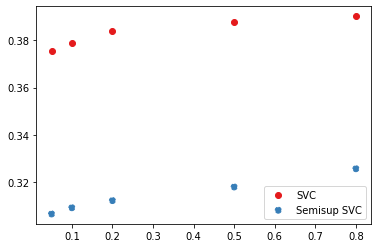

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,1)

mean_accuracies = np.mean(accuracies_array, axis=-1)

ls = ['-', '--']
colors = sns.color_palette("Set1", n_colors=mean_accuracies.shape[0])
algos = ['SVC', 'Semisup SVC']

for i, algo in enumerate(algos):
# for i, p in enumerate(prop_labeled):
#     print(mean_accuracies[0].shape, len(prop_labeled))
    ax.scatter(prop_labeled, mean_accuracies[:, i], label=algo, ls=ls[i], color=colors[i])

ax.legend()